In [1]:
cd ~/microbiome_rnn/

/Volumes/export/isn/mwiest/microbiome_rnn


In [2]:
from __future__ import print_function
%matplotlib inline
import os
import torch
import numpy as np
import sys
from otu_handler import OTUHandler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from models.rnn.conv_lstm import *
from models.rnn.lstm import *
from helpers.model_helper import *

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [3]:
run_suffix = '_h256_sl15_rns25_sif5_convTrue'
model_name = 'model{}.pt'.format(run_suffix)
log_name = 'log{}.csv'.format(run_suffix)
output_dir = 'rnn_output'


# Plot the Training Loss

In [4]:
losses = np.loadtxt(os.path.join(output_dir, log_name), delimiter=',')


Text(0.5,1,'Loss Over Training')

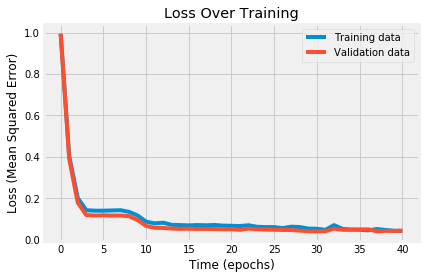

In [5]:
plt.plot(losses[0, :].T, label='Training data')
plt.plot(losses[1, :].T, label='Validation data')
plt.legend(loc='upper right')
plt.xlabel('Time (epochs)')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Loss Over Training')


# Model "Dreaming" Analysis

In [6]:
# Instantiate an OTU Handler.
input_dir = 'all_studies_reduced/'
files = []
for (dirpath, dirnames, filenames) in os.walk(input_dir):
    files.extend(filenames)
    break
files = [os.path.join(input_dir, f) for f in files if not f.endswith('_clr.csv')]
otu_handler = OTUHandler(files)
otu_handler.normalize_data()

In [7]:
# Instantiate the model
hidden_dim = 256
reduced_num_strains = 25
use_gpu = torch.cuda.is_available()
model = ConvLSTM(hidden_dim, otu_handler, use_gpu, LSTM_in_size=reduced_num_strains)
model.load_state_dict(torch.load(os.path.join(output_dir, model_name)))
model = model.cuda()

In [44]:
# Get some primer data
sample_index = 1
sample_start_range = 15
sample_end_range = 30
primer = otu_handler.samples[sample_index].values[:, sample_start_range: sample_end_range]
# Need to make it 3d because the last dimension is how many predictions to do at once. 
primer = np.expand_dims(primer, -1)
print('Sample is of shape: {}'.format(primer.shape))

Sample is of shape: (79, 15, 1)


In [45]:
dream_length = 100
dream = model.daydream(primer, serial=False, predict_len=dream_length)
print(dream.shape)

# Get the comparison data.
comparison = otu_handler.samples[sample_index].values[:, sample_start_range:dream_length + sample_end_range]

c2 = otu_handler.raw_samples[sample_index].values[:, sample_start_range:dream_length + sample_end_range]
# Unnormalize the output data.
dream_un = otu_handler.un_normalize_data(dream, sample_index, (sample_start_range, sample_end_range))
comparison_un = otu_handler.un_normalize_data(comparison, sample_index, (sample_start_range, sample_end_range))


(79, 115, 1)


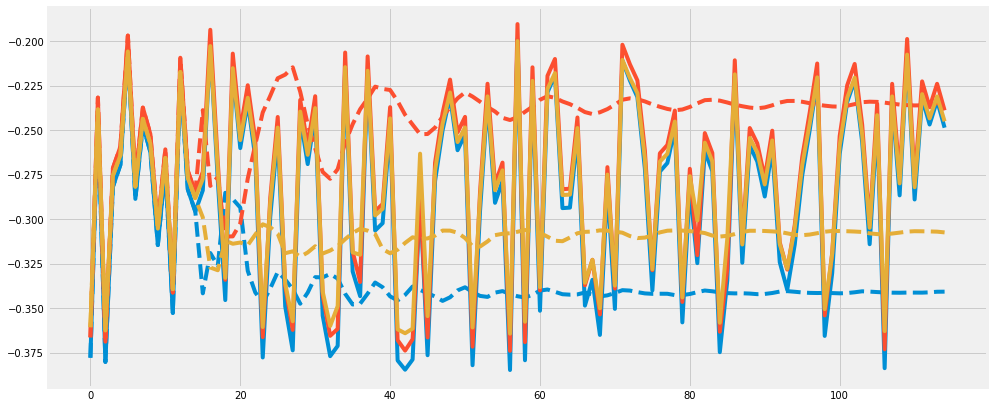

In [46]:
plt.figure(figsize=(15, 7))
r = range(0, 3)

for i, ri in enumerate(r):
    plt.plot(dream[ri, :, 0].T, ls='--', c=colors[i])
    plt.plot(comparison[ri, :].T, c=colors[i])